# Imports

In [91]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras import models, layers, losses

# Constants

In [42]:
TRAIN_DIR = "./data/Train"
TEST_DIR = "./data/Test"
CLASSES = ["Basketball", "Football", "Rowing", "Swimming", "Tennis", "Yoga"]
CLASSES = { l: i for (i, l) in enumerate(CLASSES) }
BATCH_SIZE = 20
NUM_CHANNELS = 3 # rgb
IMG_SIZE = 200
SEED = 3
# to apply augmentations
train_aug = models.Sequential([
	layers.Rescaling(scale=1.0 / 255),
	layers.RandomFlip("horizontal_and_vertical"),
	layers.RandomZoom(height_factor=(-0.05, -0.15), width_factor=(-0.05, -0.15)),
	layers.RandomRotation(0.3)
])
tf.random.set_seed(SEED)

# Utils

In [94]:
plt.style.use("dark_background")

In [43]:
def get_class_by_idx(idx):
  return list(CLASSES.keys())[list(CLASSES.values()).index(idx)]

In [44]:
import cv2
def plot_images(images_labels, n_rows, n_cols):
  """ Helper function to plot images and their corresponding labels
  @param images_labels (List[Tuple(image/tensor, string)]): (images, labels) tuple
  @param n_rows (int): number of rows
  @param n_cols (int): number of columns
  """
  fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*3, n_rows*3), squeeze=False)
  n = len(images_labels)
  for i, ax in enumerate(axes.flat):
    image, label = images_labels[i]
    ax.set_title(label, fontsize=10)
    ax.axis("off")
    ax.imshow(image)

  plt.tight_layout()
  plt.show()

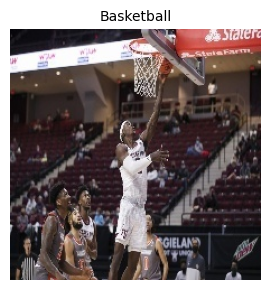

In [45]:
### Sample image
img = cv2.imread(f"{TRAIN_DIR}/Basketball_20.jpg")[:,:,::-1] # BGR to RGB,
label = "Basketball"
plot_images([(img, label)], 1, 1)

In [93]:
def plot_hist(history):

  fig, axes = plt.subplots(1, 2, figsize=(10,5))

  axes[0].set_ylim([0, 1])
  axes[0].plot(history.history['accuracy'])
  axes[0].plot(history.history['val_accuracy'])
  axes[0].set_title('model accuracy')
  axes[0].set_xlabel('epoch')
  axes[0].set_ylabel('accuracy')
  axes[0].legend(['train', 'validation'], loc='upper right')

  axes[1].plot(history.history['loss'])
  axes[1].plot(history.history['val_loss'])
  axes[1].set_title('model loss')
  axes[1].set_ylabel('loss')
  axes[1].set_xlabel('epoch')
  axes[1].legend(['train', 'validation'], loc='upper right')
  plt.show()

# Dataset generator

In [47]:
def extract_label(image_path):
  label = image_path.split("_")[0]
  label = label.split("/")[-1]
  label_idx = CLASSES[label]
  return tf.one_hot(label_idx, len(CLASSES))

def load_image(image_path):
  raw = tf.io.read_file(image_path)
  image = tf.io.decode_image(raw, channels=NUM_CHANNELS, expand_animations=False)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  print(image.shape)
  image = tf.cast(image, tf.float32) / 255.0
  return image

def process_path(filepath):
  image = load_image(filepath)
  # image = train_aug(image)
  return image

def create_dataset(train=True):
  dir = TRAIN_DIR if train else TEST_DIR
  filenames = [os.path.join(dir, i) for i in os.listdir(dir)]
  labels = [extract_label(filename) if train else "?" for filename in filenames]
  dataset = Dataset.from_tensor_slices((filenames, labels))
  dataset = dataset.map(lambda x, y: (process_path(x), y), num_parallel_calls=tf.data.AUTOTUNE)
  if train:
    dataset = dataset.shuffle(buffer_size=len(filenames))
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  return dataset

## check for balance in dataset

In [48]:
from collections import Counter
# Count the frequency of each label
label_counts = Counter([s.split("_")[0] for s in os.listdir(TRAIN_DIR)])
total = sum(label_counts.values())
print(label_counts, total)
print(total/BATCH_SIZE, "batches with", total, "total records")

Counter({'Yoga': 458, 'Football': 400, 'Swimming': 240, 'Rowing': 202, 'Basketball': 196, 'Tennis': 185}) 1681
84.05 batches with 1681 total records


In [49]:
train_val_ds = create_dataset()
val_ds = train_val_ds.take(10) # 10 BATCHES!! == 200 image
train_ds = train_val_ds.skip(10)

print(len(train_ds), "Train batches with", len(train_ds) * BATCH_SIZE, "records")
print(len(val_ds), "validation batches with", len(val_ds) * BATCH_SIZE, "records")

(200, 200, 3)
75 Train batches with 1500 records
10 validation batches with 200 records


# Training

## FCNN1

In [60]:
fcnn1 = models.Sequential([
    tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS)),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", ),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(len(CLASSES), activation="softmax")
    ])
fcnn1.compile(optimizer="adam", loss=losses.CategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
fcnn1.name = "fcnn1"
fcnn1.summary()

Model: "fcnn1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 198, 198, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 97, 97, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 147456)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │     9,437,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,457,030 (36.08 MB)

 Trainable params: 9,457,030 (36.08 MB)

 Non-trainable params: 0 (0.00 B)

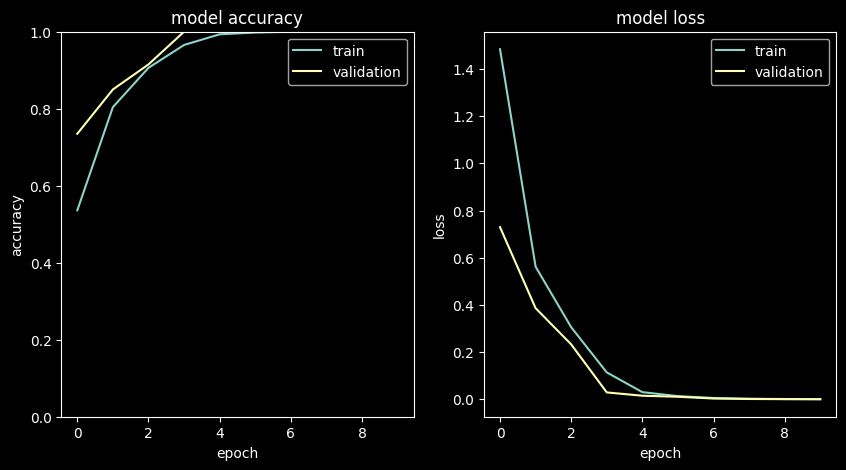

In [92]:
fcnn1_hist = fcnn1.fit(x=train_ds, validation_data=val_ds, epochs=10)
fcnn1.save(filepath="./models/fcnn1.keras")
plot_hist(fcnn1_hist)

## FCNN2

In [70]:
fcnn2 = models.Sequential([
    tf.keras.Input(shape=[IMG_SIZE, IMG_SIZE, NUM_CHANNELS]),
    layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    layers.MaxPooling2D((3, 3), strides=2),
    layers.Conv2D(filters=128, kernel_size=(5, 5), activation="relu"),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(len(CLASSES), activation="softmax"),
    ])
fcnn2.compile(optimizer="adam", loss=losses.CategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
fcnn2.name = "fcnn2"
fcnn2.summary()

Model: "fcnn2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 196, 196, 128)  │         9,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 97, 97, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 93, 93, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 42, 42, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,434,118 (20.73 MB)

 Trainable params: 5,434,118 (20.73 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
fcnn2_hist = fcnn2.fit(x=train_ds, validation_data=val_ds, epochs=10)
fcnn2.save(filepath="./models/fcnn2.keras")
plot_hist(fcnn2_hist)

## FCNN3

In [82]:
fcnn3 = models.Sequential([
    tf.keras.Input(shape=[IMG_SIZE, IMG_SIZE, NUM_CHANNELS]),
    layers.Conv2D(filters=32, kernel_size=(5, 5), activation="relu"),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu", padding="same"),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu", padding="same"),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(filters=64, kernel_size=(5, 5), activation="relu", padding="same"),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(len(CLASSES), activation="softmax"),
    ])
fcnn3.compile(optimizer="adam", loss=losses.CategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
fcnn3.name = "fcnn3"
fcnn3.summary()

Model: "fcnn3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 196, 196, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_37 (MaxPooling2D) │ (None, 65, 65, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 65, 65, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 21, 21, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 7, 7, 64)       │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 275,462 (1.05 MB)

 Trainable params: 275,462 (1.05 MB)

 Non-trainable params: 0 (0.00 B)

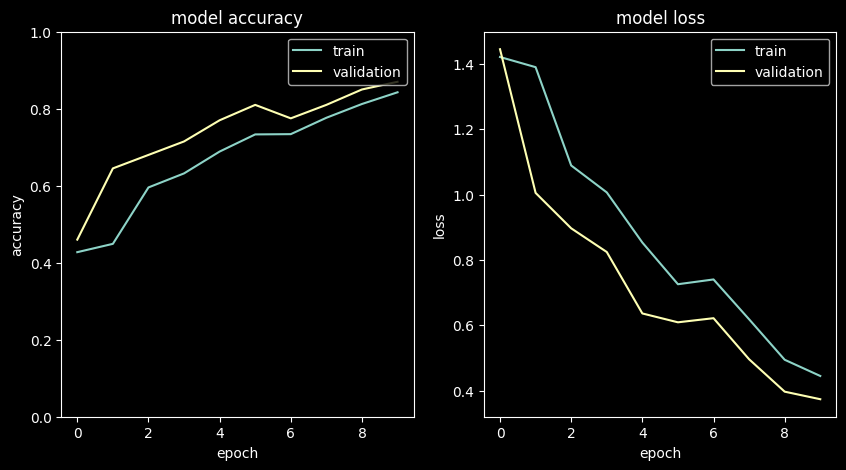

In [95]:
fcnn3_hist = fcnn3.fit(x=train_ds, validation_data=val_ds, epochs=10)
fcnn3.save(filepath="./models/fcnn3.keras")
plot_hist(fcnn3_hist)

## VGG16

In [85]:
vgg16 = models.Sequential([
	layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", input_shape=[IMG_SIZE, IMG_SIZE, NUM_CHANNELS]),
	layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
	layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
	layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.Conv2D(filters=256, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
	layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
	layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.Conv2D(filters=512, kernel_size=(3, 3), padding="same", activation="relu"),
	layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
	layers.Flatten(),
	layers.Dense(units=4096, activation="relu"),
	layers.Dense(units=4096, activation="relu"),
	layers.Dense(units=len(CLASSES), activation="softmax")
 ])
vgg16.compile(optimizer="adam", loss=losses.CategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
vgg16.name = "vgg16"
vgg16.summary()

/opt/homebrew/Caskroom/miniconda/base/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_44 (Conv2D)              │ (None, 200, 200, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 200, 200, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_46 (Conv2D)              │ (None, 100, 100, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_47 (Conv2D)              │ (None, 100, 100, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 50, 50, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_48 (Conv2D)              │ (None, 50, 50, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_49 (Conv2D)              │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_50 (Conv2D)              │ (None, 50, 50, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 25, 25, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_51 (Conv2D)              │ (None, 25, 25, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_52 (Conv2D)              │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_53 (Conv2D)              │ (None, 25, 25, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_54 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 4096)           │    75,501,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 6)              │        24,582 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,022,150 (408.26 MB)

 Trainable params: 107,022,150 (408.26 MB)

 Non-trainable params: 0 (0.00 B)

In [97]:
vgg_hist = vgg16.fit(x=train_ds, validation_data=val_ds, epochs=10)
vgg16.save(filepath="./models/vgg16.keras")
plot_hist(vgg_hist)

## AlexNet

In [87]:
alex_net = models.Sequential([
    layers.Conv2D(filters=128,kernel_size=(11, 11),strides=(4, 4),activation="relu", input_shape=[IMG_SIZE, IMG_SIZE, NUM_CHANNELS]),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Conv2D(filters=256,kernel_size=(5, 5), strides=(1, 1),activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3, 3)),
    layers.Conv2D(filters=256, kernel_size=(3, 3), strides=(1, 1), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1, 1), strides=(1, 1), activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(1024, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1024, activation="relu"),
    layers.Dense(len(CLASSES), activation="softmax")
    ])

alex_net.compile(optimizer="adam", loss=losses.CategoricalCrossentropy(from_logits=False), metrics=["accuracy"])
alex_net.name = "alex_net"
alex_net.summary()

Model: "alex_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_62 (Conv2D)              │ (None, 48, 48, 128)    │        46,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 24, 24, 256)    │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_65 (Conv2D)              │ (None, 8, 8, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 8, 8, 256)      │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_51 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_16 (Flatten)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 6)              │         6,150 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,843,398 (26.11 MB)

 Trainable params: 6,841,094 (26.10 MB)

 Non-trainable params: 2,304 (9.00 KB)

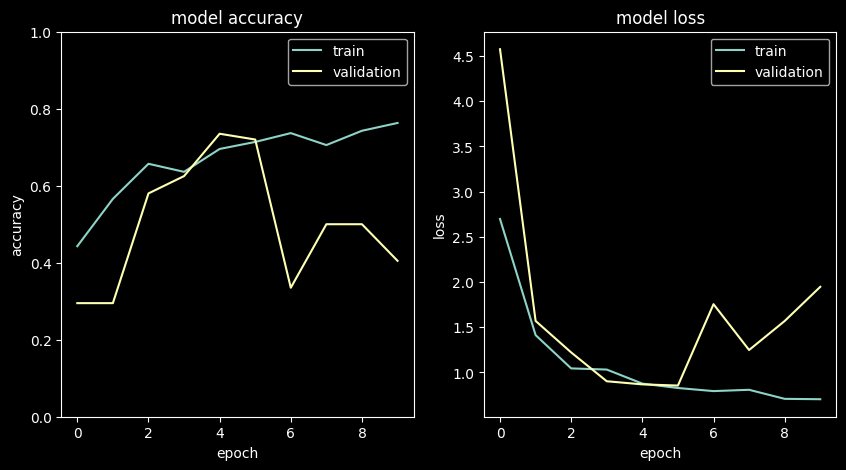

In [99]:
alex_net_hist = alex_net.fit(x=train_ds, validation_data=val_ds, epochs=10)
alex_net.save(filepath="./models/alex_net.keras")
plot_hist(alex_net_hist)

# Testing

In [63]:
test_ds = create_dataset(False)
print(len(test_ds), "Test batches with", len(test_ds) * BATCH_SIZE, "records")

(200, 200, 3)
35 Test batches with 700 records


35/35 - 1s - 43ms/step


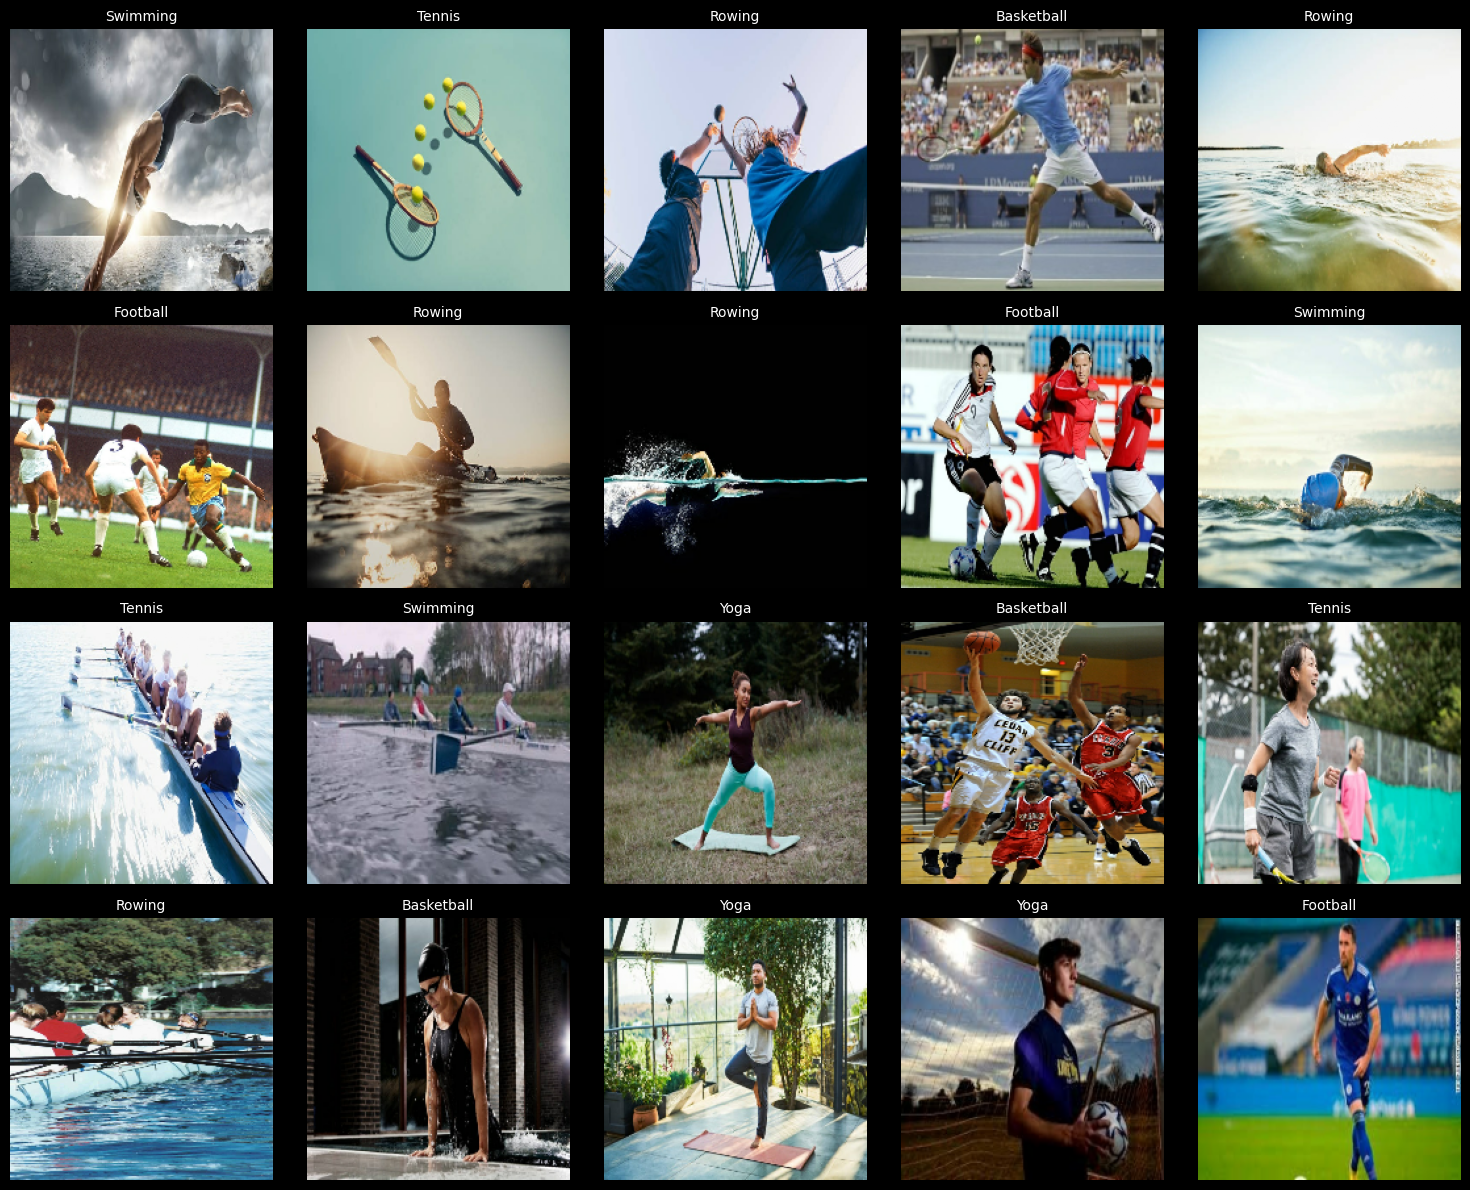

2024-04-20 20:35:18.166926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [100]:
fcnn1 = models.load_model("./models/fcnn1.keras")
fcnn1_preds = fcnn1.predict(test_ds, verbose=2)
fcnn1_preds = np.argmax(fcnn1_preds, axis=1)
for (imgs, _) in test_ds.take(1):
  imgs_lbls = [(imgs[j], get_class_by_idx(fcnn1_preds[j])) for j in range(BATCH_SIZE)]
  plot_images(imgs_lbls, BATCH_SIZE//5, 5)

In [ ]:
fcnn2 = models.load_model("./models/fcnn2.keras")
fcnn2_preds = fcnn2.predict(test_ds, verbose=2)
fcnn2_preds = np.argmax(fcnn2_preds, axis=1)
for (imgs, _) in test_ds.take(1):
  imgs_lbls = [(imgs[j], get_class_by_idx(fcnn2_preds[j])) for j in range(BATCH_SIZE)]
  plot_images(imgs_lbls, BATCH_SIZE//5, 5)

35/35 - 2s - 56ms/step


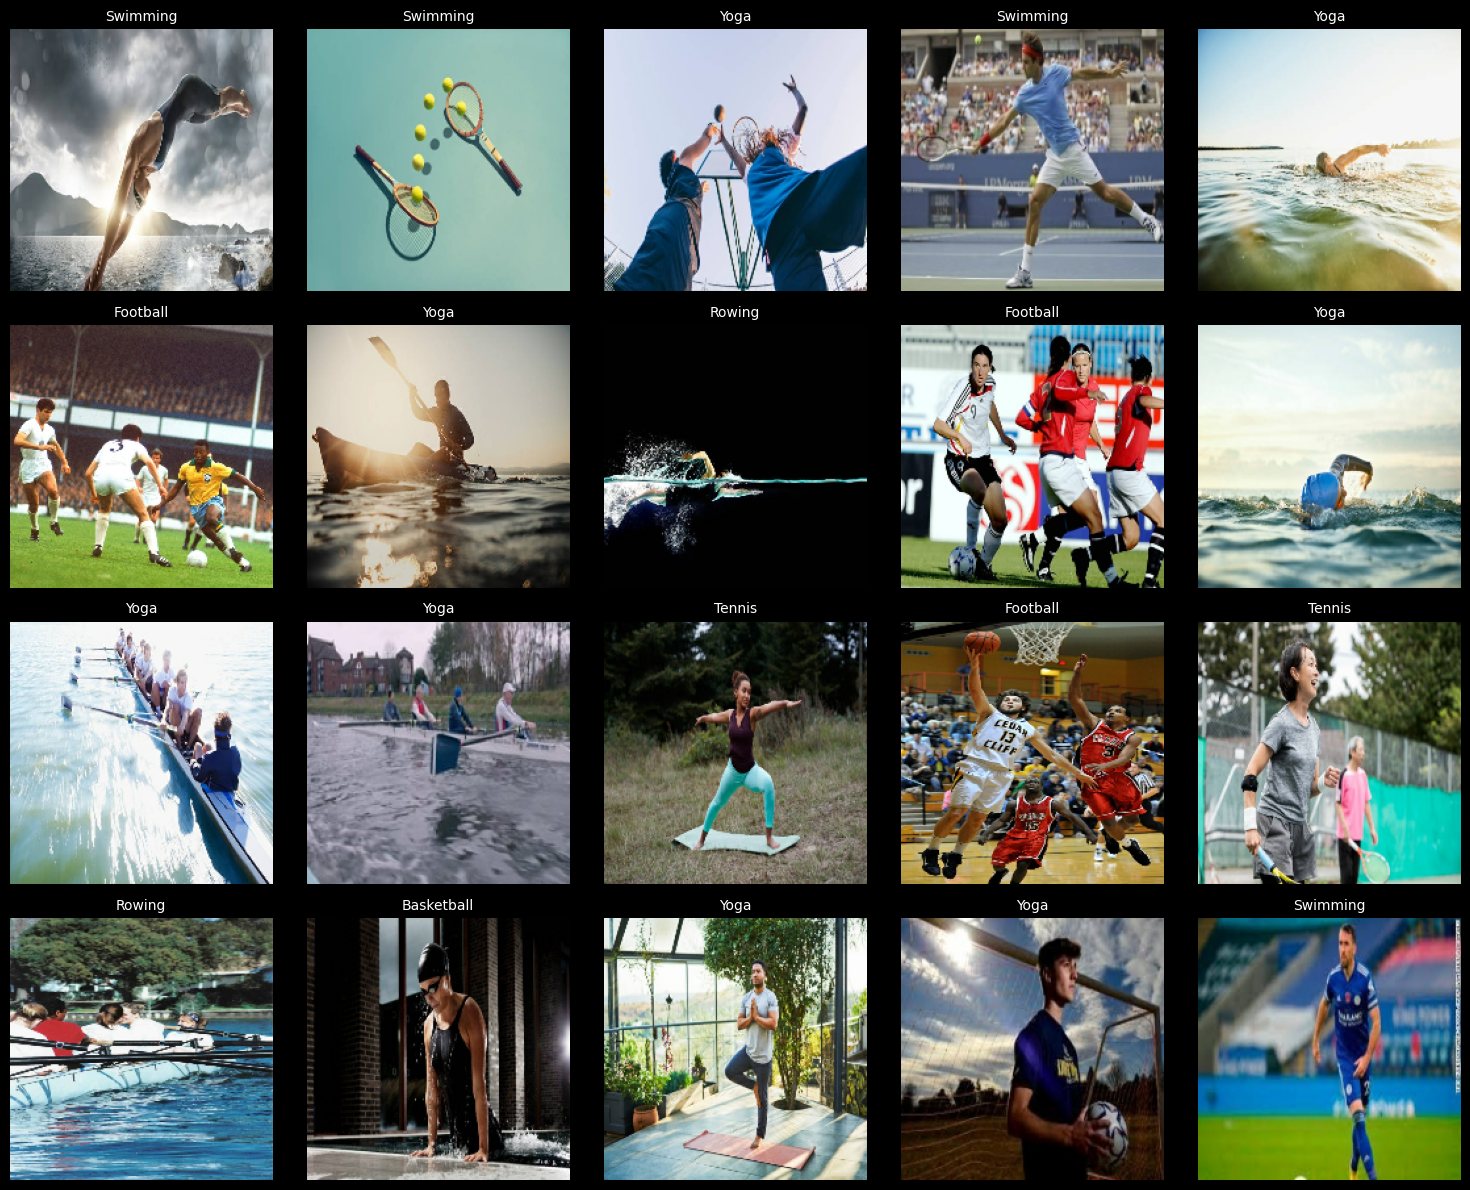

2024-04-20 20:35:48.561918: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [101]:
fcnn3 = models.load_model("./models/fcnn3.keras")
fcnn3_preds = fcnn3.predict(test_ds, verbose=2)
fcnn3_preds = np.argmax(fcnn3_preds, axis=1)
for (imgs, _) in test_ds.take(1):
  imgs_lbls = [(imgs[j], get_class_by_idx(fcnn3_preds[j])) for j in range(BATCH_SIZE)]
  plot_images(imgs_lbls, BATCH_SIZE//5, 5)

In [ ]:
vgg16 = models.load_model("./models/vgg16.keras")
vgg16_preds = vgg16.predict(test_ds, verbose=2)
vgg16_preds = np.argmax(vgg16_preds, axis=1)
for (imgs, _) in test_ds.take(1):
  imgs_lbls = [(imgs[j], get_class_by_idx(vgg16_preds[j])) for j in range(BATCH_SIZE)]
  plot_images(imgs_lbls, BATCH_SIZE//5, 5)

35/35 - 3s - 72ms/step


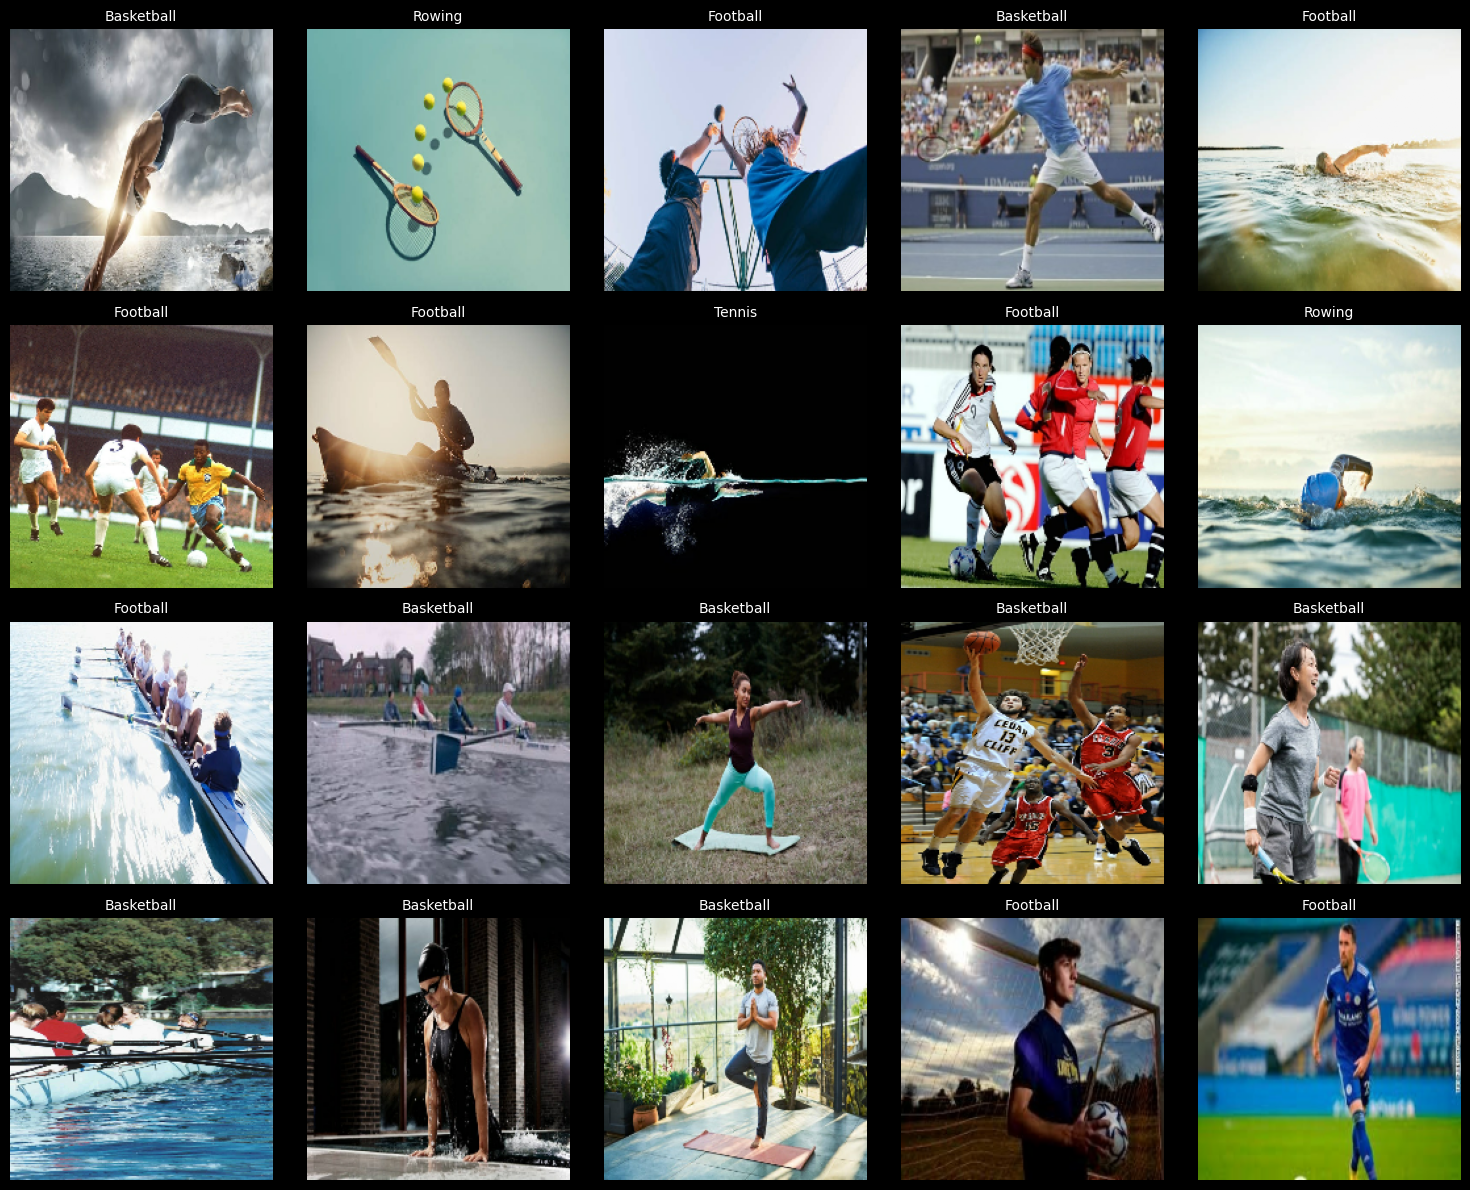

2024-04-20 20:35:55.339778: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [102]:

alex_net = models.load_model("./models/alex_net.keras")
alex_net_preds = alex_net.predict(test_ds, verbose=2)
alex_net_preds = np.argmax(alex_net_preds, axis=1)
for (imgs, _) in test_ds.take(1):
  imgs_lbls = [(imgs[j], get_class_by_idx(alex_net_preds[j])) for j in range(BATCH_SIZE)]
  plot_images(imgs_lbls, BATCH_SIZE//5, 5)